## Imports

In [1]:
import os
import shutil
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm # loading bar
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, r2_score, f1_score

import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler

In [2]:
# Check if running on Kaggle
kaggle = ('KAGGLE_KERNEL_RUN_TYPE' in os.environ)
if kaggle:
    # Code specific to Kaggle
    print("Running on Kaggle!")
else:
    print("Not running on Kaggle.")

Not running on Kaggle.


In [3]:
def extract_numbers(filename):
    filename = filename.split('.')[0] # remove extension

    split = filename.split('_')

    if len(split) > 1:
        return split[1]
    elif len(split) == 1:
        return split[0]

In [4]:
if kaggle:
    DATA_DIR = '../input/birdclef-2024/'
    OUTPUT_DIR = '/kaggle/working/'
    shutil.copy('../input/features/extracted_features.pickle', 'extracted_features.pickle')
else: # local work
    DATA_DIR = "../../data/raw/" 
    OUTPUT_DIR = "../../data/processed/"

TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "train_audio/")

train_csv_path = os.path.join(DATA_DIR, "train_metadata.csv")

# Testing
TEST_AUDIO_DIR = os.path.join(DATA_DIR,"test_soundscapes/")

# Load list of audio files by parsing the test_soundscape folder
test_file_list = sorted(os.listdir(TEST_AUDIO_DIR))
test_file_list = [file for file in test_file_list if file.endswith('.ogg')]  # Filter only ogg files

if len(test_file_list) == 0:   # replace test dir by unlabeled dir for testing
    TEST_AUDIO_DIR = os.path.join(DATA_DIR, "unlabeled_soundscapes/")
    test_file_list = sorted(os.listdir(TEST_AUDIO_DIR))
    test_file_list = [file for file in test_file_list if file.endswith('.ogg')]  # Filter only ogg files
    test_file_list = test_file_list[:5]  # Take only 5 elements to speed up debugging

test_number_list = [extract_numbers(file) for file in test_file_list]

print(f'Directory used for testing: {TEST_AUDIO_DIR}')
print(f'Number of test files: {len(test_file_list)}')

Directory used for testing: ../../data/raw/test_soundscapes/
Number of test files: 1


In [5]:
SAMPLE_RATE = 32000

## Data collection

In [6]:
data = pd.read_csv(train_csv_path)

# Add complete filepath
data['filepath'] = data.apply(lambda row: os.path.join(TRAIN_AUDIO_DIR, row['filename']), axis=1)

# # Filter out large files
# data['filesize'] = data.apply(lambda row: os.path.getsize(row['filepath']), axis=1)

In [7]:
X_files = data['filepath']
y = data['primary_label']

In [8]:
list_species = sorted(data.primary_label.unique())

In [9]:
num_classes = len(list_species)

## Features

In [10]:
def extract_features(audio_data, sample_rate=SAMPLE_RATE):
    
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    flattened_features = np.mean(mfccs, axis=1)
    
#     chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
#     features.append(np.mean(chroma, axis=1))

#     mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
#     features.append(np.mean(mel, axis=1))
    
    return flattened_features

def load_data_and_extract_features(X_files, sample_rate=SAMPLE_RATE):
    features_list = []

    for filepath in tqdm(X_files, desc='Processing files', total=len(X_files)):
        # Process data with tqdm
        audio_data, _ = librosa.load(filepath, sr=sample_rate)
        features = extract_features(audio_data, sample_rate=sample_rate)
        features_list.append(features)

    X = np.array(features_list)

    return X

In [11]:
preprocess = False

preprocessed_data_path = os.path.join(OUTPUT_DIR, 'extracted_features.pickle')
preprocessed_data_exists = os.path.exists(preprocessed_data_path)

In [12]:
if preprocess:
    X = load_data_and_extract_features(X_files)
    
    if not preprocessed_data_exists: # avoid overwriting file
        with open(preprocessed_data_path, "wb") as file:   #Pickling
            pickle.dump(X, file)
        
else:
    with open(preprocessed_data_path, "rb") as file:   # Unpickling
        X = pickle.load(file)
    

## Label Encoding

In [13]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

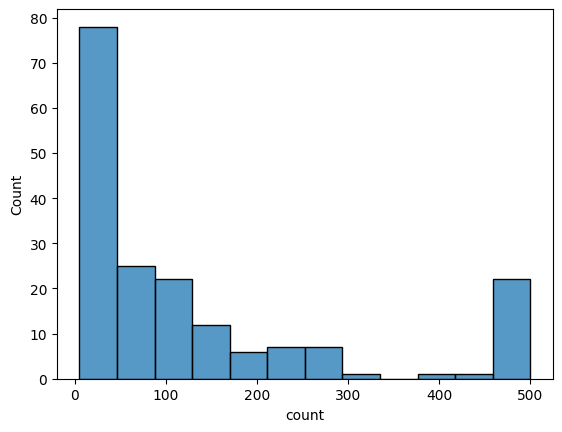

In [14]:
sns.histplot(data.primary_label.value_counts(), bins='rice');

## Train test split and Balancing

In [15]:
pd.Series(y_encoded).value_counts()

181    500
105    500
107    500
37     500
39     500
      ... 
16       6
178      6
119      5
5        5
92       5
Name: count, Length: 182, dtype: int64

In [16]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [17]:
# Rebalance after train test split!!
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [18]:
ros_val = RandomOverSampler(random_state=42)
X_val, y_val = ros_val.fit_resample(X_val, y_val)

ros_test = RandomOverSampler(random_state=42)
X_test, y_test = ros_val.fit_resample(X_test, y_test)

In [19]:
pd.Series(y_train).value_counts()

74     320
170    320
63     320
122    320
97     320
      ... 
143    320
120    320
172    320
175    320
119    320
Name: count, Length: 182, dtype: int64

## Model Training

In [20]:
def evaluate_model(model, X, y_true, prefix=''):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred, average='macro')
    metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba, average='macro', multi_class='ovr')
    
    for key, value in metrics.items():
        print(f'{prefix} {key} : {value:.2%}'.strip())
    
    return metrics

In [21]:
# Function used later to write proba to df
def proba_df(y_pred_proba):
    y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=label_encoder.classes_)
    results = pd.DataFrame({'row_id': row_id_list}) 
    results = pd.concat([results,  y_pred_proba_df], axis=1)

    # Reorder the columns to have 'row_id' first, followed by list_species
    columns_order = ['row_id'] + list_species
    results = results.reindex(columns=columns_order).fillna(0)
    
    return results

### 1. Random Forest

In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.6s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [23]:
metrics = evaluate_model(rf, X_test, y_test, prefix='Test')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.5s finished


Test accuracy : 14.17%
Test f1 : 13.67%
Test roc_auc : 69.69%


### 2. Random Forest with early stopping

In [24]:
def train_random_forest_with_early_stopping(X_train, y_train, X_val, y_val, epochs=300, patience=20, early_stopping_metric='roc_auc'):
    rf = RandomForestClassifier(n_estimators=100, warm_start=True, random_state=42, n_jobs=-1)

    best_val_metric = 0
    best_rf = None
    impatience_count = 0 

    for epoch in range(epochs): 
        rf.n_estimators += 1
        rf.fit(X_train, y_train)

        val_pred = rf.predict(X_val)
        val_pred_proba = rf.predict_proba(X_val)
        
        val_accuracy = accuracy_score(y_val, val_pred)
        val_f1 = f1_score(y_val, val_pred, average='macro')
        val_roc_auc = roc_auc_score(y_val, val_pred_proba, average='macro', multi_class='ovr')

        print(f"Epoch {epoch+1}, Validation Accuracy: {val_accuracy:.5f} - Validation F1 score: {val_f1:.5f} - Validation ROC AUC : {val_roc_auc:.5f}")

        if early_stopping_metric.lower() == 'roc_auc':
            val_metric = val_roc_auc
        elif early_stopping_metric.lower() == 'f1':
            val_metric = val_f1
        else:
            val_metric = val_accuracy
        
        if val_metric > best_val_metric:
            best_val_metric = val_metric
            best_rf = rf
            impatience_count = 0
        else:
            impatience_count += 1

        if impatience_count >= patience:
            print(f"Stopping training due to lack of improvement of {early_stopping_metric}.")
            break
            
    return best_rf


In [25]:
retrain = False
save_model = False

model_path = os.path.join(OUTPUT_DIR, 'best_rf.joblib')

In [26]:
if retrain and kaggle: # too heavy to run on local machine
    best_rf = train_random_forest_with_early_stopping(X_train, y_train, X_val, y_val)
    
    metrics = evaluate_model(best_rf, X_test, y_test, prefix='Test')
            
    if save_model:
        # Save the classifier to a file
        joblib.dump(best_rf, model_path)
        print(f"Model saved at '{model_path}'")

# else:
#     # Load the classifier from the file
#     best_rf = joblib.load(model_path)
#     print(f"Model loaded from file '{model_path}'")

### 3. XGBoost

In [31]:
# Parameters for XGBoost
params = {
    'objective' : 'multi:softmax',
    'n_estimators' : 300, # Number of boosting rounds
    'eval_metric': 'auc',       
    'random_state': 42,              
    'verbosity': 2,
    'early_stopping_rounds': 10,
    'n_jobs': -1
}


xgb_clf = xgb.XGBClassifier(**params)
xgb_clf = xgb_clf.fit(X_train, y_train, eval_set = [(X_val, y_val)])

[0]	validation_0-auc:0.57053
[1]	validation_0-auc:0.58482
[2]	validation_0-auc:0.60467
[3]	validation_0-auc:0.61091
[4]	validation_0-auc:0.62143
[5]	validation_0-auc:0.63035
[6]	validation_0-auc:0.63717
[7]	validation_0-auc:0.64372
[8]	validation_0-auc:0.65004
[9]	validation_0-auc:0.65542
[10]	validation_0-auc:0.65921
[11]	validation_0-auc:0.66351
[12]	validation_0-auc:0.66738
[13]	validation_0-auc:0.67087
[14]	validation_0-auc:0.67467
[15]	validation_0-auc:0.67858
[16]	validation_0-auc:0.68045
[17]	validation_0-auc:0.68312
[18]	validation_0-auc:0.68548
[19]	validation_0-auc:0.68856
[20]	validation_0-auc:0.69110
[21]	validation_0-auc:0.69335
[22]	validation_0-auc:0.69592
[23]	validation_0-auc:0.69764
[24]	validation_0-auc:0.69910
[25]	validation_0-auc:0.70066
[26]	validation_0-auc:0.70238
[27]	validation_0-auc:0.70369
[28]	validation_0-auc:0.70525
[29]	validation_0-auc:0.70633
[30]	validation_0-auc:0.70751
[31]	validation_0-auc:0.70902
[32]	validation_0-auc:0.70961
[33]	validation_0-au

In [32]:
metrics = evaluate_model(xgb_clf, X_test, y_test, prefix='Test')

Test accuracy : 10.26%
Test f1 : 8.88%
Test roc_auc : 72.47%


## Testing and submission

In [37]:
# Function to split audio file into chunks of given duration
def split_audio(path, duration, sr):
    sig, rate = librosa.load(path, sr=sr)
    chunk_size = duration * rate
    chunks = [sig[i:i+chunk_size] for i in range(0, len(sig), chunk_size)]
    return chunks

In [38]:
# This is where we will store our results
row_id_list = []
X_test = []

# Process audio files and make predictions with tqdm progress bar
for audio_file, file_number in tqdm(zip(test_file_list, test_number_list), total=len(test_file_list), desc='Processing test files'):
    path = os.path.join(TEST_AUDIO_DIR, audio_file)

    # Split audio file into 5-second chunks
    audio_chunks = split_audio(path, duration=5, sr=SAMPLE_RATE)

    for i, chunk in enumerate(audio_chunks):
        chunk = audio_chunks[i]
        chunk_end_time = (i + 1) * 5
        row_id = f"soundscape_{file_number}_{chunk_end_time}"
        row_id_list.append(row_id)

        features = extract_features(chunk)

        X_test.append(features)   

X_test = np.array(X_test) # convert list of 1D arrays to 2D array

Processing test files: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


In [39]:
# Select model used for predictions
best_model = xgb_clf

In [40]:
y_pred_proba = best_model.predict_proba(X_test)
results = proba_df(y_pred_proba)
results

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_22540655_5,0.000283,0.027429,6.162745e-06,6.542529e-05,5.342215e-05,9.170381e-07,1.052492e-05,3.929238e-05,0.000082,...,0.000011,2.884151e-06,0.000023,2.957318e-06,0.007643,0.000512,1.361822e-06,0.000031,0.000013,0.000050
1,soundscape_22540655_10,0.000040,0.000426,1.750728e-06,4.202385e-05,3.656977e-05,8.932103e-07,5.268418e-05,5.131653e-05,0.000050,...,0.000137,4.593927e-06,0.000028,3.386929e-06,0.011990,0.000759,1.007379e-06,0.000031,0.000008,0.000051
2,soundscape_22540655_15,0.000053,0.001120,3.037606e-06,1.381777e-05,2.213684e-05,4.147778e-07,1.692064e-05,4.678326e-06,0.000037,...,0.000042,2.591790e-06,0.000009,2.133722e-06,0.071969,0.002026,5.419967e-07,0.000029,0.000004,0.000007
3,soundscape_22540655_20,0.000030,0.000327,4.652387e-07,1.254643e-05,8.195874e-06,9.384400e-08,5.152924e-06,1.738641e-07,0.000009,...,0.000012,5.320484e-07,0.000002,6.821162e-07,0.002252,0.001034,1.110038e-07,0.000008,0.000002,0.000006
4,soundscape_22540655_25,0.000253,0.011407,2.052524e-06,7.500059e-05,4.009254e-05,8.116492e-07,1.083753e-05,1.097446e-05,0.000080,...,0.000007,7.624800e-06,0.000310,3.328316e-06,0.019841,0.000290,1.576086e-06,0.000072,0.000018,0.000037
5,soundscape_22540655_30,0.000012,0.000045,5.851333e-07,5.781676e-06,7.826518e-06,2.553086e-07,9.608162e-06,1.962223e-05,0.000005,...,0.000082,1.717016e-06,0.000009,1.252779e-06,0.003511,0.001441,3.798381e-07,0.000012,0.000004,0.000016
6,soundscape_22540655_35,0.000128,0.000067,1.338935e-06,5.315674e-05,1.299023e-05,6.583816e-07,4.268806e-06,4.394382e-06,0.000061,...,0.000014,3.397399e-06,0.000008,1.728142e-06,0.004887,0.004184,9.173718e-07,0.000020,0.000013,0.000023
7,soundscape_22540655_40,0.000135,0.000129,1.568318e-06,9.611454e-05,1.137418e-05,7.631995e-07,5.553378e-06,5.733094e-06,0.000071,...,0.000003,4.300417e-06,0.000006,2.111408e-06,0.011772,0.000407,1.018611e-06,0.000037,0.000028,0.000102
8,soundscape_22540655_45,0.000152,0.000221,3.493159e-06,2.974482e-05,8.253302e-06,8.807284e-07,3.664328e-05,6.384083e-06,0.000079,...,0.000065,2.626936e-06,0.000016,2.270572e-06,0.044264,0.001212,1.102714e-06,0.000033,0.000016,0.000121
9,soundscape_22540655_50,0.000095,0.000039,2.564289e-06,2.444281e-05,1.654135e-05,6.265360e-07,4.418348e-06,2.244446e-06,0.000077,...,0.000013,2.557926e-06,0.000010,1.518454e-06,0.093452,0.005171,5.463509e-07,0.000028,0.000012,0.000110


In [41]:
# Convert our results to csv
results.to_csv("submission.csv", index=False)